
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [1]:
## library imports here
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [28]:




# Predict CP (multiclass 0–3)
X = ha.drop("cp", axis=1)
y = ha["cp"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=321
)
ct = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), ["age", "trtbps", "chol", "thalach"])
    ],
    remainder="passthrough"
)

knn_model = Pipeline([
    ("preprocess", ct),
    ("knn", KNeighborsClassifier(n_neighbors=5))
])

knn_fit = knn_model.fit(X_train, y_train)
knn_pred = knn_fit.predict(X_test)

knn_acc = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", knn_acc)


KNN Accuracy: 0.8902439024390244


In [31]:
# Knn model with cross validation
from sklearn.model_selection import cross_val_score

# Predict CP (multiclass 0–3)
X = ha.drop("cp", axis=1)
y = ha["cp"]

ct = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), ["age", "trtbps", "chol", "thalach"])
    ],
    remainder="passthrough"
)

knn_model = Pipeline([
    ("preprocess", ct),
    ("knn", KNeighborsClassifier())
])

# 5-fold Cross-Validation
knn_cv_scores = cross_val_score(
    knn_model,
    X,
    y,
    cv=5,
    scoring="accuracy"
)

print("KNN Mean CV Accuracy:", knn_cv_scores.mean())


KNN Mean CV Accuracy: 0.9008080808080807


In [5]:
dt_model = DecisionTreeClassifier(
    max_depth=4,
    random_state=321
)

dt_fit = dt_model.fit(X_train, y_train)
dt_pred = dt_fit.predict(X_test)

dt_acc = accuracy_score(y_test, dt_pred)
print("Decision Tree Accuracy:", dt_acc)


Decision Tree Accuracy: 0.4878048780487805


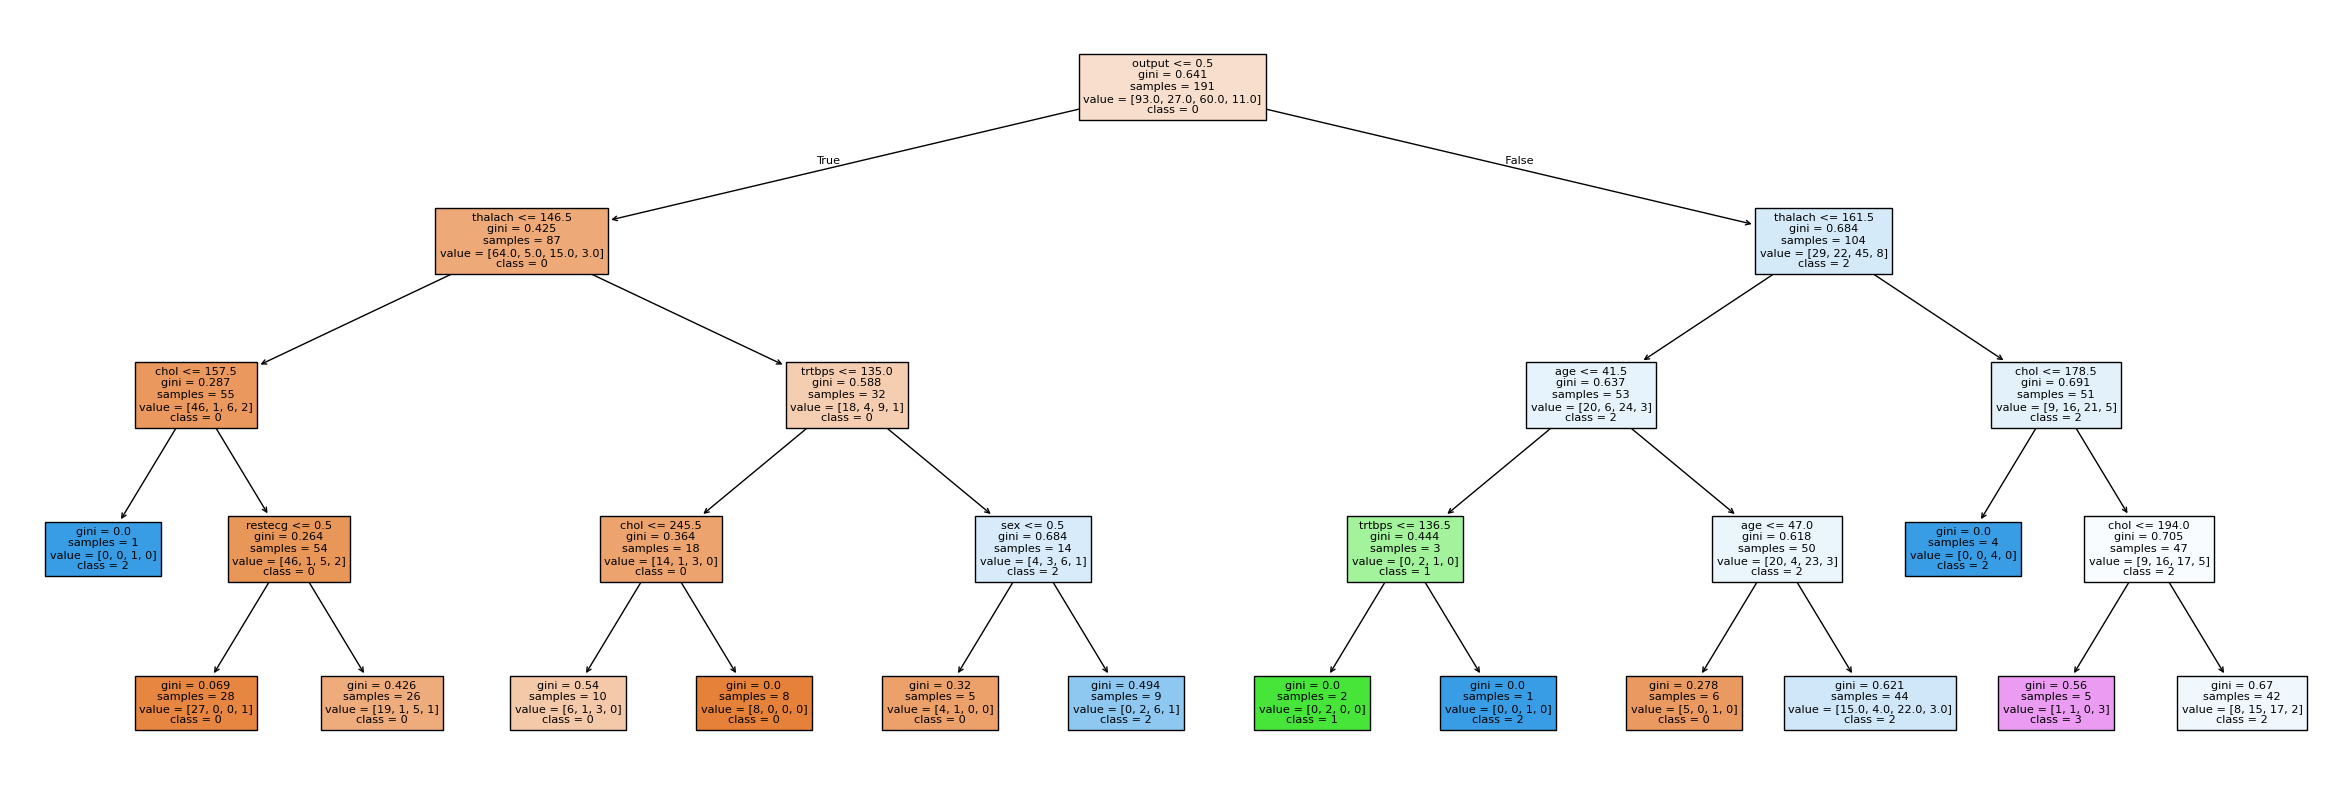

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plot_tree(dt_fit, filled=True, feature_names=X.columns, class_names=['0','1','2','3'])
plt.show()


Root split:
- output <= 0.5 -> this is the doctors diagnosis of heart attack risk (1,0)
- Left branch, patient not at risk (0)
- Right branch, patient is at risk (1)

Second split (left side):
- among patients not at risk, the next most important variable is `thalach` (max. heart rate during exercise)
- For patients not diagnosed as high-risk, chest pain type is further separated based on exercise heart rate.
- Lower max heart rate values (≤ 146.5) go one way, while higher values go another.
- This suggests that exercise-induced heart rate response is an important secondary signal for differentiating types of angina in lower-risk patients.

In [11]:
lda_model = Pipeline([
    ("preprocess", ct),
    ("lda", LinearDiscriminantAnalysis())
])

lda_fit = lda_model.fit(X_train, y_train)
lda_pred = lda_fit.predict(X_test)

lda_acc = accuracy_score(y_test, lda_pred)
print("LDA Accuracy:", lda_acc)


LDA Accuracy: 0.6341463414634146


In [26]:
#lda with cv

lda_cv_scores = cross_val_score(
    lda_model,
    X,
    y,
    cv=5,
    scoring="accuracy"
)

print("LDA Mean CV Accuracy:", lda_cv_scores.mean())


LDA Mean CV Accuracy: 0.5424242424242424


In [13]:
print("Model Accuracy Summary")
print("----------------------")
print("KNN Accuracy:", round(knn_acc, 2))
print("Decision Tree Accuracy:", round(dt_acc,2))
print("LDA Accuracy:", round(lda_acc, 2))


Model Accuracy Summary
----------------------
KNN Accuracy: 0.51
Decision Tree Accuracy: 0.49
LDA Accuracy: 0.63


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Make binary columns for each cp category
ha["cp_is_0"] = (ha["cp"] == 0).astype(int)
ha["cp_is_1"] = (ha["cp"] == 1).astype(int)
ha["cp_is_2"] = (ha["cp"] == 2).astype(int)
ha["cp_is_3"] = (ha["cp"] == 3).astype(int)

# Feature matrix (use all other columns except cp and new binary columns)
X = ha.drop(["cp", "cp_is_0", "cp_is_1", "cp_is_2", "cp_is_3"], axis=1)

# Prepare train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, ha["cp_is_3"], test_size=0.3, random_state=321
)

# Example model for cp == 3
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
pred3 = log_reg.predict(X_test)

f1_cp3 = f1_score(y_test, pred3)
print("F1 Score for cp == 3:", f1_cp3)


F1 Score for cp == 3: 0.0


In [15]:
f1_scores = {}

for cp_value in [0, 1, 2, 3]:
    y = ha[f"cp_is_{cp_value}"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=321
    )

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    score = f1_score(y_test, preds)
    f1_scores[f"cp == {cp_value}"] = score

f1_scores


{'cp == 0': 0.8, 'cp == 1': 0.1111111111111111, 'cp == 2': 0.0, 'cp == 3': 0.0}

The OvR was best at distinguishing cases where cp=0

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [16]:
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

# Subset to cp = 0 and cp = 1
ha_01 = ha[ha["cp"].isin([0, 1])].copy()

# Binary target: 0 stays 0, 1 stays 1
X = ha_01.drop("cp", axis=1)
y = ha_01["cp"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=321
)

logreg_01 = LogisticRegression(max_iter=1000)
logreg_01.fit(X_train, y_train)

# Need probabilities for AUC
probs_01 = logreg_01.predict_proba(X_test)[:, 1]

auc_01 = roc_auc_score(y_test, probs_01)
auc_01


np.float64(1.0)

In [17]:
# Subset to cp = 0 and cp = 2
ha_02 = ha[ha["cp"].isin([0, 2])].copy()

X = ha_02.drop("cp", axis=1)
y = ha_02["cp"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=321
)

logreg_02 = LogisticRegression(max_iter=1000)
logreg_02.fit(X_train, y_train)

probs_02 = logreg_02.predict_proba(X_test)[:, 1]

auc_02 = roc_auc_score(y_test, probs_02)
auc_02


np.float64(1.0)

In [18]:
# Subset to cp = 0 and cp = 3
ha_03 = ha[ha["cp"].isin([0, 3])].copy()

X = ha_03.drop("cp", axis=1)
y = ha_03["cp"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=321
)

logreg_03 = LogisticRegression(max_iter=1000)
logreg_03.fit(X_train, y_train)

probs_03 = logreg_03.predict_proba(X_test)[:, 1]

auc_03 = roc_auc_score(y_test, probs_03)
auc_03


np.float64(1.0)

For all three OvO comparisons (0 vs 1, 0 vs 2, 0 vs 3), the ROC-AUC was 1.0. This indicates perfect separability between chest pain type 0 and each of the other types using a logistic regression model. The result is consistent with the earlier OvR analysis, where cp = 0 had by far the highest F1 score, suggesting that asymptomatic patients (cp=0) are clinically distinct from the other chest pain categories. Logistic regression is therefore able to perfectly discriminate type 0 from all other groups.